In [6]:
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from IPython import display

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [8]:
# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
data_dir = 'data/hourly_energy_consumption'

label_scalers = {}

train_x = []
test_x = {}
test_y = {}

for file in os.listdir(data_dir): 
    # Skipping the files we're not using
    if file[-4:] != ".csv" or file == "pjm_hourly_est.csv":
        continue
    
    # Store csv file in a Pandas DataFrame
    df = pd.read_csv('{}/{}'.format(data_dir, file), parse_dates=[0])
    # Processing the time data into suitable input formats
    df['hour'] = df.apply(lambda x: x['Datetime'].hour,axis=1)
    df['dayofweek'] = df.apply(lambda x: x['Datetime'].dayofweek,axis=1)
    df['month'] = df.apply(lambda x: x['Datetime'].month,axis=1)
    df['dayofyear'] = df.apply(lambda x: x['Datetime'].dayofyear,axis=1)
    df = df.sort_values("Datetime").drop("Datetime",axis=1)
    
    # Scaling the input data
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)
    # Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
    label_sc.fit(df.iloc[:,0].values.reshape(-1,1))
    label_scalers[file] = label_sc
    
    # Define lookback period (window size) and split inputs/labels
    lookback = 90
    inputs = np.zeros((len(data) - lookback, lookback, df.shape[1]))
    labels = np.zeros(len(data) - lookback)
    
    for i in range(lookback, len(data)):
        inputs[i-lookback] = data[i-lookback:i]
        labels[i-lookback] = data[i,0]
    inputs = inputs.reshape(-1,lookback,df.shape[1])
    labels = labels.reshape(-1,1)
    
    # Split data into train/test portions and combining all data from different files into a single array
    test_portion = int(0.1*len(inputs))
    if len(train_x) == 0:
        train_x = inputs[:-test_portion]
        train_y = labels[:-test_portion]
    else:
        train_x = np.concatenate((train_x,inputs[:-test_portion]))
        train_y = np.concatenate((train_y,labels[:-test_portion]))
    test_x[file] = (inputs[-test_portion:])
    test_y[file] = (labels[-test_portion:])

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}

In [10]:
BATCH_SIZE = 1024 # Set the batch size to 1024

# Convert the train data into a tensor
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))

# Get batch using the torch.DataLoader
train_loader = DataLoader(
    dataset=train_data,   
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    drop_last=True, # Drop the last imcomplete batch if len(traindata) // batch_size != 0
    **kwargs # Copy the tensor to the GPU 
)

In [12]:
class GRUNet(nn.Module):
    """ Define the GRU model """

    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2) -> None:
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.relu(out[:, -1]) # Only use the final output from the GRU model
        out = self.linear(out) 
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

In [13]:
INPUT_DIM = next(iter(train_loader))[0].shape[2]
HIDDEN_DIM = 256
LR = 0.001
EPOCHS = 5

In [16]:
model = GRUNet(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, output_dim=1, n_layers=2)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [17]:
print("Starting Training of the GRU model")

epoch_time = [] # For tracking the training time
lossi = []      # For tracking the training loss

for epoch in range(EPOCHS):

    h = model.init_hidden(BATCH_SIZE) # Initialize the hidden layer
    avg_loss = 0. # Initialize the average loss
    counter = 0   # Initialize the counter to index the batch

    start_time = time.perf_counter() # Start recording the time

    for x, label in train_loader:
        counter += 1

        # Convert the hidden into a tuple
        h = h.data

        # Standard process of the training
        model.zero_grad()                                  # Initialize the gradient
        out, h = model(x.to(device).float(), h)            # Forward pass
        loss = criterion(out, label.to(device).float())    # Compute the loss
        lossi.append(loss.item())
        loss.backward()                                    # Backpropagation
        optimizer.step()                                   # Parameters update

        # Track the loss and the training state
        avg_loss += loss.item()
        if counter % 200 == 0:
            print(f'Epoch {epoch+1}... Step: {counter}/{len(train_loader)}... Average Loss: {avg_loss/counter}')

    # break

    end_time = time.perf_counter() # Finish the time recording

    print(f'Epoch {epoch+1}/{EPOCHS} Done, Total Loss: {avg_loss/len(train_loader)}')
    print(f'Total Time Elapsed: {str(end_time - start_time)} seconds')
    epoch_time.append(end_time - start_time)

print(f'Total training time: {str(sum(epoch_time))} s')


Starting Training of the GRU model
Epoch 1... Step: 200/957... Average Loss: 0.005422842335829046
Epoch 1... Step: 400/957... Average Loss: 0.0030541342977812745
Epoch 1... Step: 600/957... Average Loss: 0.0021989702760765793
Epoch 1... Step: 800/957... Average Loss: 0.0017313991407354478
Epoch 1/5 Done, Total Loss: 0.0014939193195729569
Total Time Elapsed: 56.64822240000001 seconds
Epoch 2... Step: 200/957... Average Loss: 0.00023542216753412502
Epoch 2... Step: 400/957... Average Loss: 0.00022862694026116515
Epoch 2... Step: 600/957... Average Loss: 0.00022272292446965972
Epoch 2... Step: 800/957... Average Loss: 0.00021356336748795
Epoch 2/5 Done, Total Loss: 0.0002085661174437029
Total Time Elapsed: 56.3998775 seconds
Epoch 3... Step: 200/957... Average Loss: 0.0001740058881841833
Epoch 3... Step: 400/957... Average Loss: 0.00016386709135986167
Epoch 3... Step: 600/957... Average Loss: 0.0001615176026704527
Epoch 3... Step: 800/957... Average Loss: 0.0001570294005159667
Epoch 3/5 D

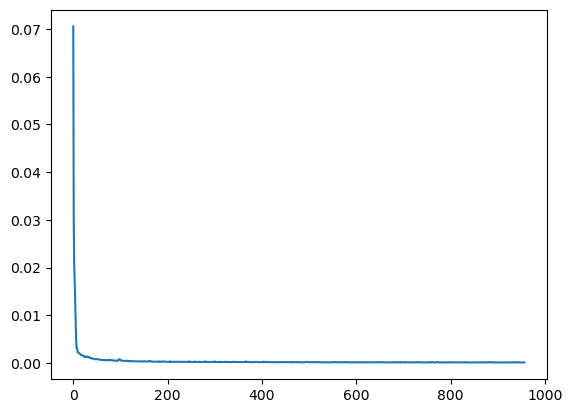

In [18]:
plt.plot(torch.tensor(lossi).view(957, -1).mean(1))

In [19]:
def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    
    start_time = time.perf_counter()

    for i in test_x.keys():
        inp = torch.from_numpy(np.array(test_x[i]))
        labs = torch.from_numpy(np.array(test_y[i]))
        h = model.init_hidden(inp.shape[0])
        out, h = model(inp.to(device).float(), h)
        outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))

    end_time = time.perf_counter()
    print("Evaluation Time: {}".format(end_time - start_time))

    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

In [20]:
gru_outputs, gru_targets, gru_sMAPE = evaluate(model, test_x, test_y, label_scalers)

Evaluation Time: 2.0084183999999823
sMAPE: 0.27171228898844896%


In [21]:
target_files = []
for file in os.listdir(data_dir):
    if file[-4:] == ".csv" and file != "pjm_hourly_est.csv":
        target_files.append(file)

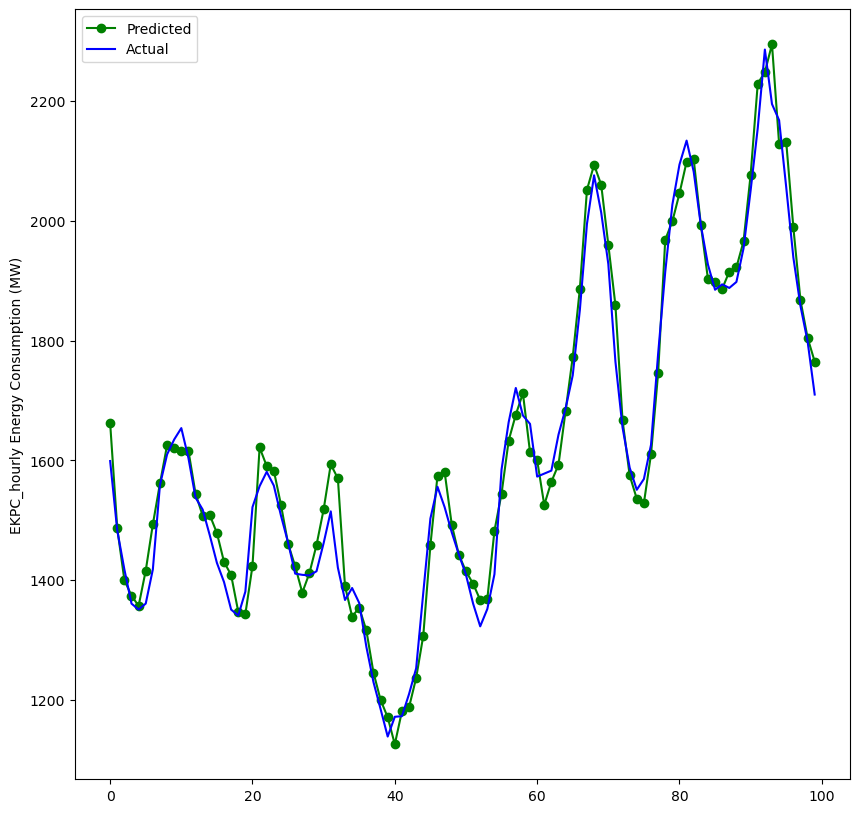

In [26]:
rand_idx = np.random.randint(0, len(gru_outputs))
plt.figure(figsize=(10, 10))
plt.plot(gru_outputs[6][:100], "-o", color="g", label="Predicted")
plt.plot(gru_targets[6][:100], color="b", label="Actual")
plt.ylabel(str(target_files[6][:-4]) + ' Energy Consumption (MW)')
plt.legend()
plt.show()

## Save the model

In [24]:
torch.save(model, 'params/time_series/gru_time_series_model')